# Workshop 11 - Network architectures (CNN vs ResNET)

Code for workshop 11.  This will use Keras (within tensorflow v2)

---
---
## 1. Initialise the environment

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os, time
import pandas as pd

# Deep Learning imports
import tensorflow as tf
from tensorflow import keras

# To plot nice figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
mpl.rc('figure', dpi=100)
import seaborn as sns; sns.set()

# Check the versions are OK (both should be 2 or more)
print(tf.__version__)
print(keras.__version__)

2.8.2
2.8.0


---
---
## 2. Load, inspect and prepare the data

We will use MNIST, which is a set of small images (28x28) that contain 10 
digits - see below for class names and an example image.

In [2]:
# This is a built-in data for keras, so easily accessible
mnist = keras.datasets.mnist
(X_train_full, y_train_full), (X_test, y_test) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [3]:
# Let's see how big it is
print(X_train_full.shape)
print(X_test.shape)
n_total = X_train_full.shape[0]

(60000, 28, 28)
(10000, 28, 28)


float64
float64
7


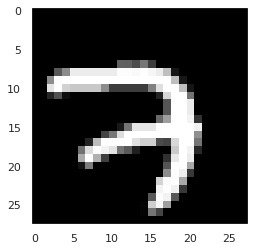

In [4]:
# Scale the data appropriately (it starts with max of 255, but we want
# max of 1)
# We will do this "by hand" here, but we could build a pipeline scaler 
# for this instead. We also split the training set given to us into 
# training and validation subsets 
# The value of 5000 samples as the size of the validation set is an 
# arbitrary choice
X_test = X_test/255.0
X_valid, X_train = X_train_full[:5000]/255.0, X_train_full[5000:]/255.0 
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
class_names = np.array([ "0","1","2","3","4","5","6","7","8","9" ])

# Inspect some aspects of the data (in general, you should play around 
# with the data more than this to get a feel for it)
# Check that scaled types are appropriate
print(X_train.dtype)
print(X_valid.dtype)
# Look at first item
print(class_names[y_train[0]])
plt.imshow(X_train[0,:,:], cmap='gray')
plt.grid(False)
plt.show()

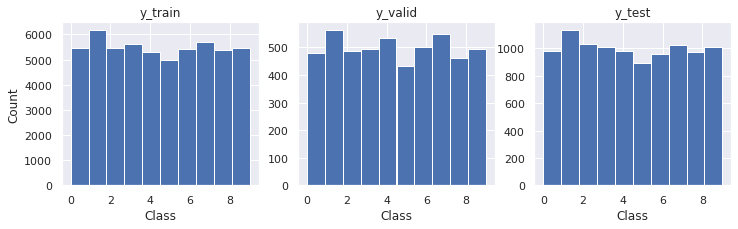

In [5]:
# Let's look at the distribution of labels in the training, validation 
# and test sets
fig, sub = plt.subplots(1, 3)
fig.set_size_inches(12,3)
sub[0].hist(y_train)
sub[0].set_ylabel('Count')
sub[0].set_xlabel('Class')
sub[0].set_title('y_train')
sub[1].hist(y_valid)
sub[1].set_xlabel('Class')
sub[1].set_title('y_valid')
sub[2].hist(y_test)
sub[2].set_xlabel('Class')
sub[2].set_title('y_test')
plt.show()

In [6]:
# Reshape the data to be shape [Nx, Ny, 1]  (previously 2D was fine, but for 
#CNN we need depth too)
X_train = X_train.reshape((-1, 28, 28, 1))
X_valid = X_valid.reshape((-1, 28, 28, 1))
X_test = X_test.reshape((-1, 28, 28, 1))

---
---
## 3. Define helper functions that build models in a parameterised way



In [7]:
# Build a CNN
def model_cnn_factory(hiddensizes, actfn, optimizer, learningrate=0):
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(filters=hiddensizes[0], kernel_size=3, 
                                  strides=1, activation=actfn, padding="same", 
                                  input_shape=[28, 28, 1]))    
                                  # input layer goes into this 2D convolution
    model.add(keras.layers.MaxPooling2D(pool_size=2))     # Pool (downsize)
    for n in hiddensizes[1:-1]:
        model.add(keras.layers.Conv2D(filters=n, kernel_size=3, strides=1, 
                                      padding="same", activation=actfn))  
                                      # 2nd Conv
        model.add(keras.layers.MaxPooling2D(pool_size=2)) # Pool (downsize)
    model.add(keras.layers.Conv2D(filters=hiddensizes[-1], kernel_size=3, 
                                  strides=1, padding="same", activation=actfn))  
                                  # 2nd Conv
    model.add(keras.layers.Flatten())          # unravel into a 1D vector
    model.add(keras.layers.Dense(10, activation = "softmax"))  
        # always have 10 classes
    model.compile(loss="sparse_categorical_crossentropy", 
                  optimizer=optimizer(learning_rate=learningrate), metrics=["accuracy"])   
    return model

# Optional aside: the CNN can become a Fully Convolutional Network (FCN) by 
# replacing the Flatten and Dense lines with model.add(keras.layers.
# Conv2D(filters=10, kernel_size=7, padding="valid", activation="softmax"))
# This uses a kernel equal to the full image size (at this point) to generate 
# a single output per filter which requires the convolution to be "valid" 
# and not "same"

In [8]:
def fit_evaluate(model, n_train, n_valid, n_epochs, batch_size, callbacks=[]):
    history = model.fit(X_train[:n_train,:,:,:], y_train[:n_train], epochs=n_epochs, callbacks = callbacks,
                        validation_data=(X_valid[:n_valid,:,:,:], y_valid[:n_valid]),verbose=1)
    max_val_acc = np.max(history.history['val_accuracy'])
    testres = model.evaluate(X_test, y_test, verbose=0)
    return (max_val_acc, testres[1], history, model)

In [9]:
def plot_history(history):
    # Plot the results (shifting validation curves appropriately)
    plt.figure(figsize=(8,5))
    n = len(history.history['accuracy'])
    plt.plot(np.arange(0,n),history.history['accuracy'], color='orange')
    plt.plot(np.arange(0,n),history.history['loss'],'b')
    plt.plot(np.arange(0,n)+0.5,history.history['val_accuracy'],'r')  # offset both validation curves
    plt.plot(np.arange(0,n)+0.5,history.history['val_loss'],'g')
    plt.legend(['Train Acc','Train Loss','Val Acc','Val Loss'])
    plt.grid(True)
    plt.gca().set_ylim(0, 1) # set the vertical range to [0-1] 
    plt.show() 

---
---
## 4. Define common modelling parameters



In [10]:
# Some key parameters
n_train = 3000
n_valid = 1000
# Define the number and size of hidden layers
hiddensizes = [16, 32, 16]
# Define the activation function to be used by hidden layers
#actfn = "relu"
actfn = "elu"
# Optimiser and learning rate
#optimizer = keras.optimizers.SGD
#learningrate = 0.01   # SGD default value
optimizer = keras.optimizers.Nadam
learningrate = 0.001   # SGD default value
# Set size of batch and number of epochs
batch_size = 32
n_epochs = 30

In [11]:
# Early stopping callback - this is executed when fitting and will 
# stop and restore best result
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                                  patience=5, 
                                                  restore_best_weights=True) 

---
---
## 5. Build a simple Convolutional Neural Network

We will use the keras version built into tensorflow version 2.
It is remarkably simple for building, training and evaluating networks.

In [12]:
#valacc, testacc, history, model = do_all(hiddensizes, actfn, optimizer, learningrate, n_train, n_valid, n_epochs, batch_size)
model = model_cnn_factory(hiddensizes, actfn, optimizer, learningrate)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 16)          4624      
                                                                 
 flatten (Flatten)           (None, 784)               0

In [13]:
# Fit and evaluate the model
valacc, testacc, history, model = fit_evaluate(model, n_train, n_valid, n_epochs, batch_size, 
                                               callbacks=early_stopping_cb)

Epoch 1/30
94/94 [==============================] - 4s 30ms/step - loss: 0.9489 - accuracy: 0.7267 - val_loss: 0.4058 - val_accuracy: 0.8810
Epoch 2/30
94/94 [==============================] - 3s 27ms/step - loss: 0.2765 - accuracy: 0.9183 - val_loss: 0.3401 - val_accuracy: 0.8890
Epoch 3/30
94/94 [==============================] - 3s 28ms/step - loss: 0.1897 - accuracy: 0.9463 - val_loss: 0.2267 - val_accuracy: 0.9430
Epoch 4/30
94/94 [==============================] - 3s 27ms/step - loss: 0.1377 - accuracy: 0.9613 - val_loss: 0.1963 - val_accuracy: 0.9440
Epoch 5/30
94/94 [==============================] - 3s 27ms/step - loss: 0.1083 - accuracy: 0.9693 - val_loss: 0.2038 - val_accuracy: 0.9410
Epoch 6/30
94/94 [==============================] - 3s 27ms/step - loss: 0.0813 - accuracy: 0.9743 - val_loss: 0.1789 - val_accuracy: 0.9510
Epoch 7/30
94/94 [==============================] - 3s 27ms/step - loss: 0.0648 - accuracy: 0.9790 - val_loss: 0.1813 - val_accuracy: 0.9540
Epoch 8/30
94

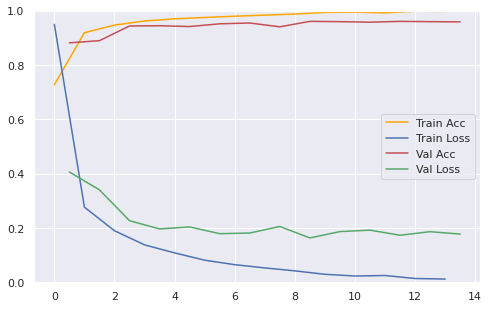

In [14]:
# Inspect the training process
plot_history(history)

In [15]:
# Now run the model on the test set and get results (loss and accuracy 
# both reported)
testres = model.evaluate(X_test, y_test, verbose=0)
print(testres)

[0.13640159368515015, 0.9599000215530396]


[7 2 1]
['7' '2' '1']
['7' '2' '1']


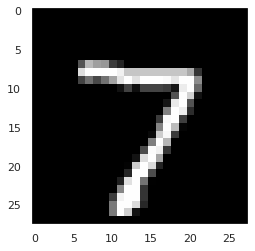

In [16]:
# We can inspect the output class predictions
y_pred = np.argmax(model.predict(X_test[:3]), axis=-1)  
    # use the first three test cases as an example
print(y_pred)   # predicted classes
print(class_names[y_pred])   # names of these classes (prediction)
print(class_names[y_test[:3]])   # names of true classes
# Display an image of the first test sample
plt.imshow(X_test[0].reshape((28,28)), cmap="gray")
plt.grid(False)

In [17]:
# We can also look at the probability of predicting each class rather than the class with max probability
# Each row has ten probabilities (one per class)
y_proba = model.predict(X_test[:3])
print(y_proba.round(2))  # round to two decimal places when printing

[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


---
---
## 6. Build a small ResNet and run on same data



In [18]:
# Implementation example of Geron: Hands On Machine Learning 2019, Chapter 14
class ResidualUnit (keras.layers.Layer): 
    def __init__ (self, filters, strides=1, activation="relu", **kwargs): 
        super(). __init__ (**kwargs) 
        self.activation = keras.activations.get(activation) 
        self.main_layers = [ 
            keras.layers.Conv2D(filters, 3, strides=strides, 
                                padding="same", use_bias=False), 
            keras.layers.BatchNormalization(), 
            self.activation, 
            keras.layers.Conv2D(filters, 3, strides=1, 
                                padding="same", use_bias=False), 
            keras.layers.BatchNormalization()] 
        self.skip_layers = [] 
        if strides > 1: 
            self.skip_layers = [ 
                keras.layers.Conv2D(filters, 1, strides=strides, 
                                    padding="same", use_bias=False), 
                keras.layers.BatchNormalization()] 
            
    def call(self, inputs): 
        Z = inputs 
        for layer in self.main_layers: 
            Z = layer(Z) 
        skip_Z = inputs 
        for layer in self.skip_layers: 
            skip_Z = layer(skip_Z) 
        return self.activation(Z + skip_Z)


In [19]:
# Build a model manually, because we want to take layers into our own hands 
#(This can be wrapped into a function later for automation.)
initial_filters=32
residual_unit_filters=[32, 64, 128]

model = keras.models.Sequential() 
model.add(keras.layers.Conv2D(initial_filters, 7, strides=2, 
                              input_shape=[28, 28, 1], 
                              padding="same", use_bias=False))
model.add(keras.layers.BatchNormalization()) 
model.add(keras.layers.Activation(actfn)) 
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same")) 

prev_filters = initial_filters
for filters in residual_unit_filters: 
    if filters == prev_filters: 
        strides = 1
    else:
        strides = 2
    model.add(ResidualUnit(filters, strides=strides)) 
    prev_filters = filters 
    
model.add(keras.layers.GlobalAvgPool2D()) 
model.add(keras.layers.Flatten()) 
model.add(keras.layers.Dense(10, activation="softmax"))

model.compile(loss="sparse_categorical_crossentropy", 
              optimizer=optimizer(learning_rate=learningrate), 
              metrics=["accuracy"])   

# Output the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 14, 14, 32)        1568      
                                                                 
 batch_normalization (BatchN  (None, 14, 14, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 14, 14, 32)        0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 residual_unit (ResidualUnit  (None, 7, 7, 32)         18688     
 )                                                               
                                                      

In [20]:
# Fit and evaluate the model
valacc, testacc, history, model = fit_evaluate(model, n_train, n_valid, 
                                               n_epochs, batch_size, callbacks=early_stopping_cb)

Epoch 1/30
94/94 [==============================] - 8s 58ms/step - loss: 0.4262 - accuracy: 0.8837 - val_loss: 2.0401 - val_accuracy: 0.2470
Epoch 2/30
94/94 [==============================] - 5s 56ms/step - loss: 0.1109 - accuracy: 0.9720 - val_loss: 1.8329 - val_accuracy: 0.2690
Epoch 3/30
94/94 [==============================] - 5s 58ms/step - loss: 0.0644 - accuracy: 0.9807 - val_loss: 1.2300 - val_accuracy: 0.5510
Epoch 4/30
94/94 [==============================] - 6s 68ms/step - loss: 0.0283 - accuracy: 0.9910 - val_loss: 0.4875 - val_accuracy: 0.8480
Epoch 5/30
94/94 [==============================] - 5s 58ms/step - loss: 0.0249 - accuracy: 0.9943 - val_loss: 0.2828 - val_accuracy: 0.9150
Epoch 6/30
94/94 [==============================] - 6s 59ms/step - loss: 0.0232 - accuracy: 0.9933 - val_loss: 0.1506 - val_accuracy: 0.9620
Epoch 7/30
94/94 [==============================] - 5s 58ms/step - loss: 0.0125 - accuracy: 0.9977 - val_loss: 0.1422 - val_accuracy: 0.9610
Epoch 8/30
94

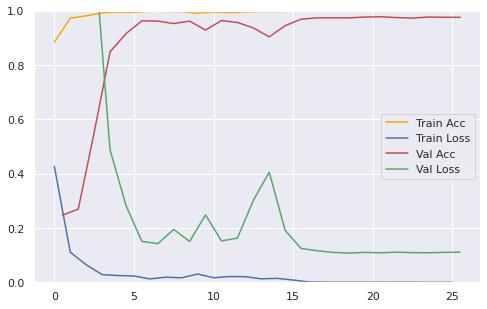

In [21]:
# Inspect the training process
plot_history(history)

In [22]:
# Now run the model on the test set and get results (loss and accuracy both reported)
testres = model.evaluate(X_test, y_test, verbose=0)
print(testres)

[0.0757901594042778, 0.9807000160217285]


[7 2 1]
['7' '2' '1']
['7' '2' '1']


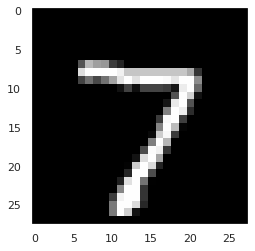

In [23]:
# We can inspect the output class predictions
y_pred = np.argmax(model.predict(X_test[:3]), axis=-1)  # use the first three test cases as an example
print(y_pred)   # predicted classes
print(class_names[y_pred])   # names of these classes (prediction)
print(class_names[y_test[:3]])   # names of true classes
# Display an image of the first test sample
plt.imshow(X_test[0].reshape((28,28)), cmap="gray")
plt.grid(False)

In [24]:
# We can also look at the probability of predicting each class rather than the class with max probability
# Each row has ten probabilities (one per class)
y_proba = model.predict(X_test[:3])
print(y_proba.round(2))  # round to two decimal places when printing

[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


---
---
## 7. Your Task

- Filter size: change the ResNet architecture to a series of 2 Residual Units with same filter size of 8, then 16, 32, 64, 128. Which one appears best?
- Number of residual units: use 32 filters per RU, change the number of RUs from 1 to 2,3,4,5,6. Which one appears best?

Write your answers and findings below:

Answer: